In [1]:
!pip install optuna --quiet

In [2]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

[I 2025-08-05 07:39:48,839] A new study created in memory with name: no-name-5838e070-e0ff-4564-bebc-5b745392b479
[I 2025-08-05 07:40:12,500] Trial 0 finished with value: 0.6303712648286781 and parameters: {'hidden1': 216, 'hidden2': 112, 'lr': 0.006859564215473063, 'batch_size': 128}. Best is trial 0 with value: 0.6303712648286781.
[I 2025-08-05 07:40:22,071] Trial 1 finished with value: 0.6368078713639516 and parameters: {'hidden1': 93, 'hidden2': 114, 'lr': 0.008092023529507565, 'batch_size': 512}. Best is trial 1 with value: 0.6368078713639516.
[I 2025-08-05 07:40:35,234] Trial 2 finished with value: 0.6359974654638336 and parameters: {'hidden1': 179, 'hidden2': 56, 'lr': 0.009310298818517351, 'batch_size': 128}. Best is trial 1 with value: 0.6368078713639516.
[I 2025-08-05 07:40:55,926] Trial 3 finished with value: 0.6497667825164232 and parameters: {'hidden1': 167, 'hidden2': 126, 'lr': 0.0008382688255330094, 'batch_size': 128}. Best is trial 3 with value: 0.6497667825164232.
[I 

🔧 Best Params: {'hidden1': 167, 'hidden2': 126, 'lr': 0.0008382688255330094, 'batch_size': 128}

📊 최종 F1 Score: 0.6439 (Best Threshold = 0.46999999999999986)
              precision    recall  f1-score   support

      재직자(0)       0.65      0.63      0.64      2000
      퇴사자(1)       0.64      0.66      0.65      2000

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000



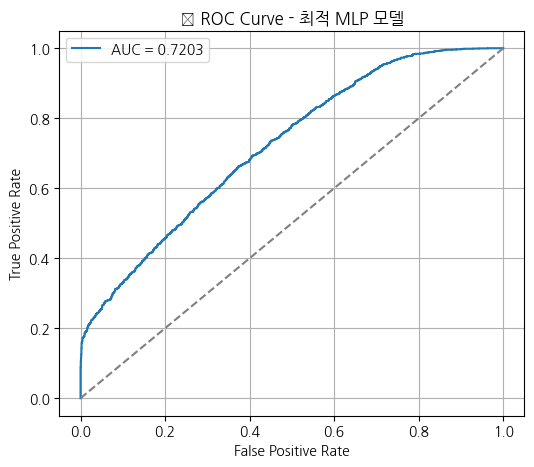

In [3]:
### 하이퍼파라미터, OPTUMA 최적화한 결과의 딥러닝 모음

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
import optuna
import warnings
warnings.filterwarnings("ignore")

# 📌 데이터 로드 및 전처리
df = pd.read_csv('/content/employee_new3.csv')
df = df[df['Gender'] != 'Other']
df['Resigned'] = df['Resigned'].astype(int)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=['Resigned', 'Employee_ID', 'Hire_Date'], errors='ignore')
y = df['Resigned']

# 클래스 균형 맞춤
X_0 = X[y == 0].sample(n=10000, random_state=42)
y_0 = y[y == 0].sample(n=10000, random_state=42)
X_1 = X[y == 1]
y_1 = y[y == 1]
repeat_count = 10000 // len(X_1) + 1
X_1_sampled = pd.concat([X_1] * repeat_count)[:10000].reset_index(drop=True)
y_1_sampled = pd.concat([y_1] * repeat_count)[:10000].reset_index(drop=True)
X_balanced = pd.concat([X_0, X_1_sampled]).reset_index(drop=True)
y_balanced = pd.concat([y_0, y_1_sampled]).reset_index(drop=True)

X_balanced = X_balanced.fillna(X_balanced.mean(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# 🧠 MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Linear(hidden2, 1)
        )
    def forward(self, x): return self.model(x)

# 🔁 학습 함수
def train(model, loader, lr, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_test_tensor)).numpy().flatten()
    return probs

# 📊 평가 함수 (F1 기준 threshold 찾기)
def evaluate(y_true, probs):
    best_f1, best_th = 0, 0.5
    for th in np.arange(0.1, 0.9, 0.01):
        pred = (probs >= th).astype(int)
        f1_0 = f1_score(y_true, pred, pos_label=0)
        f1_1 = f1_score(y_true, pred, pos_label=1)
        avg = (f1_0 + f1_1) / 2
        if avg > best_f1:
            best_f1 = avg
            best_th = th
    final_pred = (probs >= best_th).astype(int)
    report = classification_report(y_true, final_pred, output_dict=True)
    return best_f1, best_th, report, final_pred

# 🎯 Optuna 튜닝 objective 함수
def objective(trial):
    hidden1 = trial.suggest_int('hidden1', 64, 256)
    hidden2 = trial.suggest_int('hidden2', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    epochs = 30

    model = MLP(X_train.shape[1], hidden1, hidden2)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    probs = train(model, train_loader, lr, epochs)
    f1, _, _, _ = evaluate(y_test, probs)
    return f1

# 🧪 Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# ✅ 최적 모델 학습 및 평가
best_params = study.best_params
print("🔧 Best Params:", best_params)

best_model = MLP(X_train.shape[1], best_params['hidden1'], best_params['hidden2'])
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params['batch_size'], shuffle=True)
probs = train(best_model, train_loader, best_params['lr'], epochs=30)
f1, best_th, report, preds = evaluate(y_test, probs)

print(f"\n📊 최종 F1 Score: {f1:.4f} (Best Threshold = {best_th})")
print(classification_report(y_test, preds, target_names=["재직자(0)", "퇴사자(1)"]))

# 📈 ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - 최적 MLP 모델")
plt.legend()
plt.grid()
plt.show()

[I 2025-08-05 07:42:22,533] A new study created in memory with name: no-name-83da3c18-4759-451c-b283-3fac67688987


📉 Epoch 1: Validation Loss = 0.6462
📉 Epoch 2: Validation Loss = 0.6432
📉 Epoch 3: Validation Loss = 0.6395
📉 Epoch 4: Validation Loss = 0.6385
📉 Epoch 5: Validation Loss = 0.6355
📉 Epoch 6: Validation Loss = 0.6336
📉 Epoch 7: Validation Loss = 0.6311
📉 Epoch 8: Validation Loss = 0.6255
📉 Epoch 9: Validation Loss = 0.6247
📉 Epoch 10: Validation Loss = 0.6199
📉 Epoch 11: Validation Loss = 0.6183
📉 Epoch 12: Validation Loss = 0.6171
📉 Epoch 13: Validation Loss = 0.6134
📉 Epoch 14: Validation Loss = 0.6127
📉 Epoch 15: Validation Loss = 0.6109
📉 Epoch 16: Validation Loss = 0.6097
📉 Epoch 17: Validation Loss = 0.6063
📉 Epoch 18: Validation Loss = 0.6053
📉 Epoch 19: Validation Loss = 0.6041
📉 Epoch 20: Validation Loss = 0.6009
📉 Epoch 21: Validation Loss = 0.5974
📉 Epoch 22: Validation Loss = 0.5987
📉 Epoch 23: Validation Loss = 0.5963
📉 Epoch 24: Validation Loss = 0.5947
📉 Epoch 25: Validation Loss = 0.5937
📉 Epoch 26: Validation Loss = 0.5950
📉 Epoch 27: Validation Loss = 0.5882
📉 Epoch 28

[I 2025-08-05 07:42:37,465] Trial 0 finished with value: 0.6409022356336513 and parameters: {'hidden1': 211, 'hidden2': 44, 'lr': 0.0003642726617711624, 'batch_size': 128}. Best is trial 0 with value: 0.6409022356336513.


📉 Epoch 1: Validation Loss = 0.6734
📉 Epoch 2: Validation Loss = 0.6582
📉 Epoch 3: Validation Loss = 0.6488
📉 Epoch 4: Validation Loss = 0.6457
📉 Epoch 5: Validation Loss = 0.6445
📉 Epoch 6: Validation Loss = 0.6439
📉 Epoch 7: Validation Loss = 0.6437
📉 Epoch 8: Validation Loss = 0.6432
📉 Epoch 9: Validation Loss = 0.6431
📉 Epoch 10: Validation Loss = 0.6426
📉 Epoch 11: Validation Loss = 0.6423
📉 Epoch 12: Validation Loss = 0.6419
📉 Epoch 13: Validation Loss = 0.6415
📉 Epoch 14: Validation Loss = 0.6412
📉 Epoch 15: Validation Loss = 0.6413
📉 Epoch 16: Validation Loss = 0.6406
📉 Epoch 17: Validation Loss = 0.6403
📉 Epoch 18: Validation Loss = 0.6396
📉 Epoch 19: Validation Loss = 0.6389
📉 Epoch 20: Validation Loss = 0.6385
📉 Epoch 21: Validation Loss = 0.6380
📉 Epoch 22: Validation Loss = 0.6375
📉 Epoch 23: Validation Loss = 0.6369
📉 Epoch 24: Validation Loss = 0.6363
📉 Epoch 25: Validation Loss = 0.6357
📉 Epoch 26: Validation Loss = 0.6352
📉 Epoch 27: Validation Loss = 0.6346
📉 Epoch 28

[I 2025-08-05 07:42:48,206] Trial 1 finished with value: 0.614796227204191 and parameters: {'hidden1': 201, 'hidden2': 87, 'lr': 0.00010402475255841186, 'batch_size': 256}. Best is trial 0 with value: 0.6409022356336513.


📉 Epoch 1: Validation Loss = 0.6348
📉 Epoch 2: Validation Loss = 0.6246
📉 Epoch 3: Validation Loss = 0.6048
📉 Epoch 4: Validation Loss = 0.5954
📉 Epoch 5: Validation Loss = 0.5907
📉 Epoch 6: Validation Loss = 0.5807
📉 Epoch 7: Validation Loss = 0.5784
📉 Epoch 8: Validation Loss = 0.5770
📉 Epoch 9: Validation Loss = 0.5694
📉 Epoch 10: Validation Loss = 0.5649
📉 Epoch 11: Validation Loss = 0.5733
📉 Epoch 12: Validation Loss = 0.5716
📉 Epoch 13: Validation Loss = 0.5682
📉 Epoch 14: Validation Loss = 0.5804
📉 Epoch 15: Validation Loss = 0.5710
⛔ Early stopping triggered!


[I 2025-08-05 07:42:53,562] Trial 2 finished with value: 0.6467465918149984 and parameters: {'hidden1': 126, 'hidden2': 43, 'lr': 0.002559461700662456, 'batch_size': 128}. Best is trial 2 with value: 0.6467465918149984.


📉 Epoch 1: Validation Loss = 0.6737
📉 Epoch 2: Validation Loss = 0.6564
📉 Epoch 3: Validation Loss = 0.6461
📉 Epoch 4: Validation Loss = 0.6434
📉 Epoch 5: Validation Loss = 0.6425
📉 Epoch 6: Validation Loss = 0.6413
📉 Epoch 7: Validation Loss = 0.6403
📉 Epoch 8: Validation Loss = 0.6395
📉 Epoch 9: Validation Loss = 0.6394
📉 Epoch 10: Validation Loss = 0.6389
📉 Epoch 11: Validation Loss = 0.6381
📉 Epoch 12: Validation Loss = 0.6372
📉 Epoch 13: Validation Loss = 0.6370
📉 Epoch 14: Validation Loss = 0.6363
📉 Epoch 15: Validation Loss = 0.6364
📉 Epoch 16: Validation Loss = 0.6347
📉 Epoch 17: Validation Loss = 0.6339
📉 Epoch 18: Validation Loss = 0.6334
📉 Epoch 19: Validation Loss = 0.6327
📉 Epoch 20: Validation Loss = 0.6318
📉 Epoch 21: Validation Loss = 0.6306
📉 Epoch 22: Validation Loss = 0.6302
📉 Epoch 23: Validation Loss = 0.6289
📉 Epoch 24: Validation Loss = 0.6283
📉 Epoch 25: Validation Loss = 0.6277
📉 Epoch 26: Validation Loss = 0.6269
📉 Epoch 27: Validation Loss = 0.6262
📉 Epoch 28

[I 2025-08-05 07:43:02,728] Trial 3 finished with value: 0.6163384990613996 and parameters: {'hidden1': 201, 'hidden2': 37, 'lr': 0.00027106484192516723, 'batch_size': 512}. Best is trial 2 with value: 0.6467465918149984.


📉 Epoch 1: Validation Loss = 0.6262
📉 Epoch 2: Validation Loss = 0.6118
📉 Epoch 3: Validation Loss = 0.5889
📉 Epoch 4: Validation Loss = 0.6018
📉 Epoch 5: Validation Loss = 0.5786
📉 Epoch 6: Validation Loss = 0.5705
📉 Epoch 7: Validation Loss = 0.5886
📉 Epoch 8: Validation Loss = 0.5515
📉 Epoch 9: Validation Loss = 0.5624
📉 Epoch 10: Validation Loss = 0.5530
📉 Epoch 11: Validation Loss = 0.5621
📉 Epoch 12: Validation Loss = 0.5526
📉 Epoch 13: Validation Loss = 0.5738
⛔ Early stopping triggered!


[I 2025-08-05 07:43:09,221] Trial 4 finished with value: 0.6498353475059131 and parameters: {'hidden1': 200, 'hidden2': 74, 'lr': 0.008040853765733618, 'batch_size': 128}. Best is trial 4 with value: 0.6498353475059131.


📉 Epoch 1: Validation Loss = 0.6434
📉 Epoch 2: Validation Loss = 0.6396
📉 Epoch 3: Validation Loss = 0.6279
📉 Epoch 4: Validation Loss = 0.6149
📉 Epoch 5: Validation Loss = 0.6119
📉 Epoch 6: Validation Loss = 0.6013
📉 Epoch 7: Validation Loss = 0.5969
📉 Epoch 8: Validation Loss = 0.5869
📉 Epoch 9: Validation Loss = 0.5871
📉 Epoch 10: Validation Loss = 0.5729
📉 Epoch 11: Validation Loss = 0.5744
📉 Epoch 12: Validation Loss = 0.5683
📉 Epoch 13: Validation Loss = 0.5710
📉 Epoch 14: Validation Loss = 0.5753
📉 Epoch 15: Validation Loss = 0.5707
📉 Epoch 16: Validation Loss = 0.5732
📉 Epoch 17: Validation Loss = 0.5781
⛔ Early stopping triggered!


[I 2025-08-05 07:43:14,272] Trial 5 finished with value: 0.649736317824915 and parameters: {'hidden1': 171, 'hidden2': 62, 'lr': 0.001834175316540646, 'batch_size': 256}. Best is trial 4 with value: 0.6498353475059131.


📉 Epoch 1: Validation Loss = 0.6386
📉 Epoch 2: Validation Loss = 0.6192
📉 Epoch 3: Validation Loss = 0.6052
📉 Epoch 4: Validation Loss = 0.5939
📉 Epoch 5: Validation Loss = 0.5881
📉 Epoch 6: Validation Loss = 0.5795
📉 Epoch 7: Validation Loss = 0.5751
📉 Epoch 8: Validation Loss = 0.5763
📉 Epoch 9: Validation Loss = 0.5635
📉 Epoch 10: Validation Loss = 0.5615
📉 Epoch 11: Validation Loss = 0.5645
📉 Epoch 12: Validation Loss = 0.5636
📉 Epoch 13: Validation Loss = 0.5647
📉 Epoch 14: Validation Loss = 0.5750
📉 Epoch 15: Validation Loss = 0.5865
⛔ Early stopping triggered!


[I 2025-08-05 07:43:19,160] Trial 6 finished with value: 0.6457249410209674 and parameters: {'hidden1': 77, 'hidden2': 97, 'lr': 0.005213536607418948, 'batch_size': 256}. Best is trial 4 with value: 0.6498353475059131.


📉 Epoch 1: Validation Loss = 0.6786
📉 Epoch 2: Validation Loss = 0.6641
📉 Epoch 3: Validation Loss = 0.6530
📉 Epoch 4: Validation Loss = 0.6474
📉 Epoch 5: Validation Loss = 0.6443
📉 Epoch 6: Validation Loss = 0.6435
📉 Epoch 7: Validation Loss = 0.6424
📉 Epoch 8: Validation Loss = 0.6415
📉 Epoch 9: Validation Loss = 0.6412
📉 Epoch 10: Validation Loss = 0.6407
📉 Epoch 11: Validation Loss = 0.6402
📉 Epoch 12: Validation Loss = 0.6399
📉 Epoch 13: Validation Loss = 0.6394
📉 Epoch 14: Validation Loss = 0.6395
📉 Epoch 15: Validation Loss = 0.6390
📉 Epoch 16: Validation Loss = 0.6389
📉 Epoch 17: Validation Loss = 0.6384
📉 Epoch 18: Validation Loss = 0.6388
📉 Epoch 19: Validation Loss = 0.6378
📉 Epoch 20: Validation Loss = 0.6374
📉 Epoch 21: Validation Loss = 0.6370
📉 Epoch 22: Validation Loss = 0.6366
📉 Epoch 23: Validation Loss = 0.6359
📉 Epoch 24: Validation Loss = 0.6355
📉 Epoch 25: Validation Loss = 0.6350
📉 Epoch 26: Validation Loss = 0.6341
📉 Epoch 27: Validation Loss = 0.6339
📉 Epoch 28

[I 2025-08-05 07:43:28,567] Trial 7 finished with value: 0.6129810360707675 and parameters: {'hidden1': 256, 'hidden2': 75, 'lr': 0.00013189665331960618, 'batch_size': 512}. Best is trial 4 with value: 0.6498353475059131.


📉 Epoch 1: Validation Loss = 0.6417
📉 Epoch 2: Validation Loss = 0.6395
📉 Epoch 3: Validation Loss = 0.6364
📉 Epoch 4: Validation Loss = 0.6335
📉 Epoch 5: Validation Loss = 0.6328
📉 Epoch 6: Validation Loss = 0.6269
📉 Epoch 7: Validation Loss = 0.6226
📉 Epoch 8: Validation Loss = 0.6188
📉 Epoch 9: Validation Loss = 0.6165
📉 Epoch 10: Validation Loss = 0.6101
📉 Epoch 11: Validation Loss = 0.6086
📉 Epoch 12: Validation Loss = 0.6066
📉 Epoch 13: Validation Loss = 0.6032
📉 Epoch 14: Validation Loss = 0.6016
📉 Epoch 15: Validation Loss = 0.5980
📉 Epoch 16: Validation Loss = 0.5954
📉 Epoch 17: Validation Loss = 0.5917
📉 Epoch 18: Validation Loss = 0.5910
📉 Epoch 19: Validation Loss = 0.5902
📉 Epoch 20: Validation Loss = 0.5850
📉 Epoch 21: Validation Loss = 0.5866
📉 Epoch 22: Validation Loss = 0.5815
📉 Epoch 23: Validation Loss = 0.5847
📉 Epoch 24: Validation Loss = 0.5838
📉 Epoch 25: Validation Loss = 0.5792
📉 Epoch 26: Validation Loss = 0.5774
📉 Epoch 27: Validation Loss = 0.5786
📉 Epoch 28

[I 2025-08-05 07:43:39,084] Trial 8 finished with value: 0.6406770349804157 and parameters: {'hidden1': 153, 'hidden2': 66, 'lr': 0.0006747245398610678, 'batch_size': 256}. Best is trial 4 with value: 0.6498353475059131.


📉 Epoch 1: Validation Loss = 0.6377
📉 Epoch 2: Validation Loss = 0.6185
📉 Epoch 3: Validation Loss = 0.6102
📉 Epoch 4: Validation Loss = 0.5953
📉 Epoch 5: Validation Loss = 0.5830
📉 Epoch 6: Validation Loss = 0.5801
📉 Epoch 7: Validation Loss = 0.5818
📉 Epoch 8: Validation Loss = 0.5791
📉 Epoch 9: Validation Loss = 0.5637
📉 Epoch 10: Validation Loss = 0.5698
📉 Epoch 11: Validation Loss = 0.5622
📉 Epoch 12: Validation Loss = 0.5617
📉 Epoch 13: Validation Loss = 0.5714
📉 Epoch 14: Validation Loss = 0.5733
📉 Epoch 15: Validation Loss = 0.5751
📉 Epoch 16: Validation Loss = 0.5750
⛔ Early stopping triggered!


[I 2025-08-05 07:43:46,011] Trial 9 finished with value: 0.6455528355773154 and parameters: {'hidden1': 203, 'hidden2': 80, 'lr': 0.0017407836373780495, 'batch_size': 128}. Best is trial 4 with value: 0.6498353475059131.


🔧 Best Params: {'hidden1': 200, 'hidden2': 74, 'lr': 0.008040853765733618, 'batch_size': 128}
📉 Epoch 1: Validation Loss = 0.6332
📉 Epoch 2: Validation Loss = 0.6033
📉 Epoch 3: Validation Loss = 0.5996
📉 Epoch 4: Validation Loss = 0.5846
📉 Epoch 5: Validation Loss = 0.5706
📉 Epoch 6: Validation Loss = 0.5873
📉 Epoch 7: Validation Loss = 0.5606
📉 Epoch 8: Validation Loss = 0.5820
📉 Epoch 9: Validation Loss = 0.5625
📉 Epoch 10: Validation Loss = 0.5659
📉 Epoch 11: Validation Loss = 0.5587
📉 Epoch 12: Validation Loss = 0.5844
📉 Epoch 13: Validation Loss = 0.5623
📉 Epoch 14: Validation Loss = 0.5660
📉 Epoch 15: Validation Loss = 0.5874
📉 Epoch 16: Validation Loss = 0.5875
⛔ Early stopping triggered!

📊 최종 F1 Score: 0.6447 (Best Threshold = 0.5399999999999998)
              precision    recall  f1-score   support

      재직자(0)       0.73      0.48      0.58      2000
      퇴사자(1)       0.62      0.82      0.71      2000

    accuracy                           0.66      4000
   macro avg    

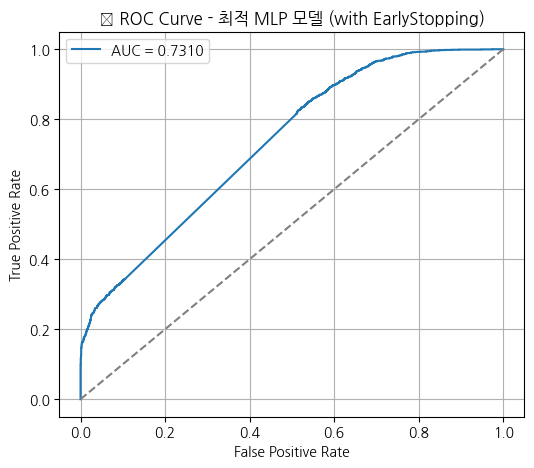

In [4]:
### Earlystopping을 사용한 MLP 하이퍼파라미터 튜닝 모델

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
import optuna
import warnings
warnings.filterwarnings("ignore")

# 📌 데이터 로드 및 전처리
df = pd.read_csv('/content/employee_new3.csv')
df = df[df['Gender'] != 'Other']
df['Resigned'] = df['Resigned'].astype(int)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=['Resigned', 'Employee_ID', 'Hire_Date'], errors='ignore')
y = df['Resigned']

# 클래스 균형 맞춤
X_0 = X[y == 0].sample(n=10000, random_state=42)
y_0 = y[y == 0].sample(n=10000, random_state=42)
X_1 = X[y == 1]
y_1 = y[y == 1]
repeat_count = 10000 // len(X_1) + 1
X_1_sampled = pd.concat([X_1] * repeat_count)[:10000].reset_index(drop=True)
y_1_sampled = pd.concat([y_1] * repeat_count)[:10000].reset_index(drop=True)
X_balanced = pd.concat([X_0, X_1_sampled]).reset_index(drop=True)
y_balanced = pd.concat([y_0, y_1_sampled]).reset_index(drop=True)

X_balanced = X_balanced.fillna(X_balanced.mean(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# 🧠 MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Linear(hidden2, 1)
        )
    def forward(self, x): return self.model(x)

# ⏹️ EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 🔁 학습 함수 (with early stopping)
def train(model, loader, lr, epochs, val_data=None, use_earlystop=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    early_stopping = EarlyStopping(patience=5, min_delta=0.001) if use_earlystop else None

    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

        if use_earlystop and val_data is not None:
            model.eval()
            with torch.no_grad():
                val_x, val_y = val_data
                val_pred = model(val_x)
                val_loss = criterion(val_pred, val_y).item()
                print(f"📉 Epoch {epoch+1}: Validation Loss = {val_loss:.4f}")
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("⛔ Early stopping triggered!")
                    break
            model.train()

    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_test_tensor)).numpy().flatten()
    return probs

# 📊 평가 함수 (F1 기준 threshold 찾기)
def evaluate(y_true, probs):
    best_f1, best_th = 0, 0.5
    for th in np.arange(0.1, 0.9, 0.01):
        pred = (probs >= th).astype(int)
        f1_0 = f1_score(y_true, pred, pos_label=0)
        f1_1 = f1_score(y_true, pred, pos_label=1)
        avg = (f1_0 + f1_1) / 2
        if avg > best_f1:
            best_f1 = avg
            best_th = th
    final_pred = (probs >= best_th).astype(int)
    report = classification_report(y_true, final_pred, output_dict=True)
    return best_f1, best_th, report, final_pred

# 🎯 Optuna 튜닝 objective 함수
def objective(trial):
    hidden1 = trial.suggest_int('hidden1', 64, 256)
    hidden2 = trial.suggest_int('hidden2', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    epochs = 30

    model = MLP(X_train.shape[1], hidden1, hidden2)

    # ⚠️ 훈련 데이터를 train/val 나누기 (early stopping용)
    full_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_size = int(0.1 * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_x, val_y = val_ds[:][0], val_ds[:][1]

    probs = train(model, train_loader, lr, epochs, val_data=(val_x, val_y), use_earlystop=True)
    f1, _, _, _ = evaluate(y_test, probs)
    return f1

# 🧪 Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# ✅ 최적 모델 학습 및 평가
best_params = study.best_params
print("🔧 Best Params:", best_params)

best_model = MLP(X_train.shape[1], best_params['hidden1'], best_params['hidden2'])

# 재학습 (early stopping 다시 사용)
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(0.1 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True)
val_x, val_y = val_ds[:][0], val_ds[:][1]

probs = train(best_model, train_loader, best_params['lr'], epochs=30, val_data=(val_x, val_y), use_earlystop=True)
f1, best_th, report, preds = evaluate(y_test, probs)

print(f"\n📊 최종 F1 Score: {f1:.4f} (Best Threshold = {best_th})")
print(classification_report(y_test, preds, target_names=["재직자(0)", "퇴사자(1)"]))

# 📈 ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - 최적 MLP 모델 (with EarlyStopping)")
plt.legend()
plt.grid()
plt.show()